#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import diffusion_utils

import networkx as nx

from copy import deepcopy

from tqdm import tqdm

import random

from itertools import combinations

In [116]:
import importlib
importlib.reload(diffusion_utils)

<module 'diffusion_utils' from '/Users/oseckin/Documents/GitHub/belief_network_extended/notebooks/../scripts/diffusion_utils.py'>

## Star Network Belief Systems

#### Create the social network

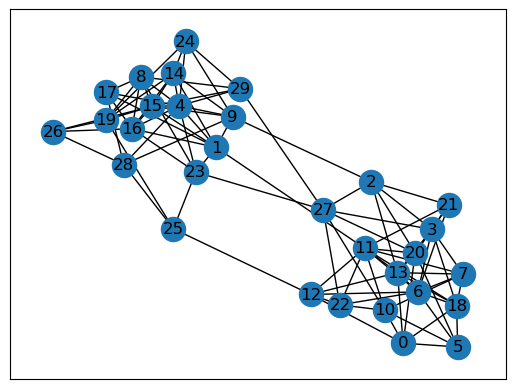

In [2]:
N = 30
M = 100
mu = .05

social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

nx.draw_networkx(social_G)

#### Generate and embed the belief networks inside the social network

In [3]:
social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

#### Random walk to close triads

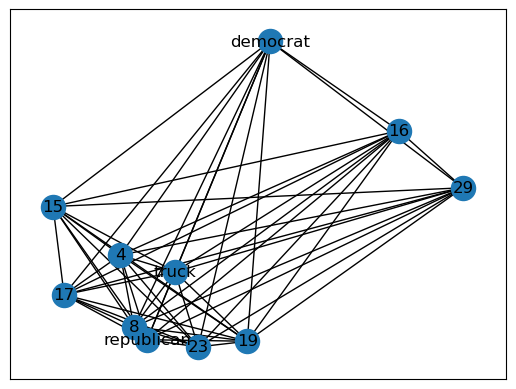

In [4]:
g = social_G.nodes[8]['belief_network']

nx.draw_networkx(g)

In [5]:
del g

In [6]:
def get_avg_measures(social_G):
    
    temp1 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    temp2 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    for e in social_G.edges():
        w1 = social_G.nodes[e[0]]['belief_network'].edges[e]['weight']
        w2 = social_G.nodes[e[1]]['belief_network'].edges[e]['weight']

        diff = abs(w1 - w2)
        comm1 = communities[e[0]] + "s"
        comm2 = communities[e[1]] + "s"
        
        if comm1 != comm2:
            temp1['inter-group'].append(diff)
            temp2['inter-group'].append(w1)
            temp2['inter-group'].append(w2)
        else:
            temp1['intra-group'].append(diff)
            temp2['intra-group'].append(w1)
            temp2['intra-group'].append(w2)
        
        temp1['aggregate'].append(diff)
        temp2['aggregate'].append(w1)
        temp2['aggregate'].append(w2)
    
    return temp1, temp2

In [7]:
def random_walker(g, focal_edge):
    
    node_order = list(g.nodes())
    #print("Node Order:", node_order)

    # Create mappings
    index_to_node = {i: node for i, node in enumerate(node_order)}
    node_to_index = {node: i for i, node in enumerate(node_order)}
    
    # get the adjacency matrix
    adj = nx.adjacency_matrix(g)

    # take the absolute value of all
    abs_adj = abs(adj)

    # sum of columns will be used to normalize the values
    normalizer = abs_adj.sum(axis=0)

    # normalize the values columnwise
    abs_adj_normalized = abs_adj/normalizer

    # probabilities for a two-step random walk
    random_walk_probs = (abs_adj_normalized**2).todense()

    # choose one of the nodes from the edge as the starter node
    i = np.random.choice([0,1])
    starting_node = focal_edge[i]
    middle_node = focal_edge[i-1]

    # determine the column number of the middle node in the adj matrix
    col = node_to_index[middle_node]

    # extract the probabilities that starting from the starter node,
    # what are the probabilities ending up in the other nodes in k jumps?
    probabilities = random_walk_probs[:,col].flatten()

    # choose a node depending on the probabilities
    ending_node = random.choices(node_order, weights=probabilities, k=1)[0]

    return starting_node, middle_node, ending_node

In [8]:
def assign_weight_to_new_edge(g, starting_node, middle_node, ending_node):
    
    # compute the multiplication of starting to middle and middle to ending node edges
    curr_multiplication = g.edges[(starting_node, middle_node)]['weight'] * g.edges[(middle_node, ending_node)]['weight']
    
    # assign a random initial weight drawn from normal distribution that ensures cognitive
    # consonance for the triad

    dissonant = True

    while dissonant:
        initial_weight = np.random.normal(0, .2)
        if curr_multiplication * initial_weight < 0:
            dissonant = False
    
    return initial_weight

In [9]:
G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

# embed the belief networks into social networks
G = diffusion_utils.generate_embed_belief_networks_to_social_network(G, communities)

In [59]:
focal_edge

('truck', 7)

In [66]:
social_G.nodes[receiver]['belief_network'].edges()

EdgeView([(26, 14), (26, 15), (26, 12), (26, 24), (26, 'republican'), (26, 'democrat'), (26, 'truck'), (14, 'truck'), (14, 24), (14, 'republican'), (14, 15), (14, 'democrat'), (14, 12), (15, 24), (15, 12), (15, 'truck'), (15, 'democrat'), (15, 'republican'), (12, 'republican'), (12, 24), (12, 'truck'), (12, 'democrat'), (24, 'truck'), (24, 'republican'), (24, 'democrat'), ('republican', 'truck'), ('republican', 'democrat'), ('democrat', 'truck')])

In [78]:
not social_G.nodes[receiver]['belief_network'].has_edge(focal_edge[0],focal_edge[1])

True

In [103]:
sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_mutual_belief(social_G)

In [104]:
sender

22

In [ ]:
alpha = 1.5
beta = 1

N = 30
M = 100
mu = .05

networks = {}
log = {}

for sim in range(50):
    
    # initialize the social network
    social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

    # embed the belief networks into social networks
    social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)
    
    #networks[0] = deepcopy(social_G)

    avg_diff = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    avg_w = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    
    T = N * 600
    
    for t in tqdm(range(T+1)):
        
        # Randomly choose a sender, receiver and focal edge
        sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_mutual_belief(social_G)
        
        # Receiver's belief about democrat or republican cannot be changed 
        cond1 = frozenset(focal_edge) == frozenset(('republican', receiver))
        cond2 = frozenset(focal_edge) == frozenset(('democrat', receiver))
        
        # if the edge does not exist at all in the receiver's belief system, we don't update
        cond3 = (not social_G.nodes[receiver]['belief_network'].has_edge(focal_edge[0],focal_edge[1]))
        
        # if none of these hold, do the update
        if not (cond1 or cond2 or cond3):
            
            # Calculate the updated weight after agents interact
            b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender, receiver, 
                                                                  focal_edge, alpha=alpha, beta=beta)

            # Update the belief in the network
            diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                               b_i_plus_1)
        
        # RANDOM WALK
        # Extract the receiver's belief network
        g = social_G.nodes[receiver]['belief_network']
        
        # Agent thinks to themselves after updating their belief (apply random walk)
        starting_node, middle_node, ending_node = random_walker(g, focal_edge)
        
        # If starting node is the same as the ending node,
        if (starting_node == ending_node):
            
            focal_edge = (starting_node, middle_node)
            
            b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender=None, receiver=receiver, 
                                                                  focal_edge=focal_edge, alpha=alpha, beta=beta)

            # Update the belief in the network
            diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                               b_i_plus_1)

        
        # If starting node and ending nodes are existing: 
        elif g.has_edge(starting_node, ending_node):
            
            focal_edge = (starting_node, ending_node)
            
            b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender=None, receiver=receiver, 
                                                                  focal_edge=focal_edge, alpha=alpha, beta=beta)

            # Update the belief in the network
            diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                               b_i_plus_1)
            
        # If not, we randomly assign a weight to the new edge
        else:
            pass
        
        temp1, temp2 = get_avg_measures(social_G)
        
        for k,v in temp1.items():
            avg_diff[k].append(np.mean(v))
        
        for k,v in temp2.items():
            avg_w[k].append(np.mean(v))

        #if t % 500 == 0:
        #    networks[t] = deepcopy(social_G)
    
    log[sim] = {}
    log[sim]['avg_diff'] = avg_diff
    log[sim]['avg_w'] = avg_w
    
    break

 12%|███████████████████▋                                                                                                                                              | 2190/18001 [02:12<20:54, 12.60it/s]

In [57]:
diffusion_utils.choose_sender_receiver_focal_edge(G)

(22, 21, (21, 2))

(4, 'democrat')

Community: democrat
Weight toward republican: {'weight': -1}
Weight toward democrat: {'weight': 1}


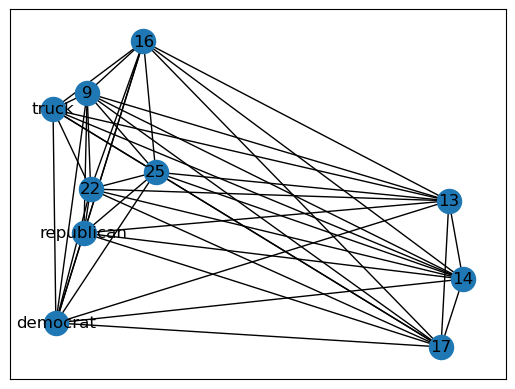

In [99]:
node = 22
nx.draw_networkx(social_G.nodes[node]['belief_network'])

print("Community:", communities[node])

print("Weight toward republican:", social_G.nodes[node]['belief_network'].edges[(node,'republican')])
print("Weight toward democrat:", social_G.nodes[node]['belief_network'].edges[(node,'democrat')])

In [101]:
# find neighbors and select one
neighbor = random.choice([*social_G.neighbors(node)])
print(neighbor)
communities[neighbor]

13


'democrat'

In [102]:
social_G.nodes[node]['belief_network'].edges[(node,neighbor)]

{'weight': -1}

In [103]:
social_G.nodes[neighbor]['belief_network'].edges[(node,neighbor)]

{'weight': -1}

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_70397/2972752697.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


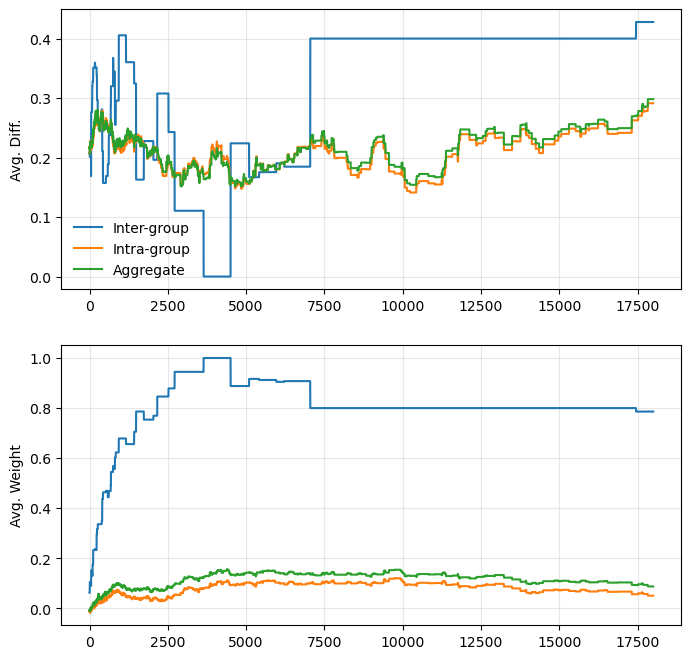

In [105]:
fig, axs = plt.subplots(2,1,figsize=(8,8))

for i, d, ylabel in zip([0,1], ['avg_diff', 'avg_w'], ['Avg. Diff.', 'Avg. Weight']):
    for l in ['inter-group', 'intra-group', 'aggregate']:
        avg = np.mean([v[d][l] for v in log.values()], axis=0)
        std = np.std([v[d][l] for v in log.values()], axis=0)
        axs[i].plot(avg, 
                    label=l.capitalize())
        
        axs[i].fill_between(range(len(avg)),
                            avg+(std/2), avg-(std/2),
                            alpha=.3)
    
    axs[i].set_ylabel(ylabel)
    axs[i].grid(alpha=.3)
    
axs[0].legend(frameon=False)

fig.show()

In [275]:
[social_G.nodes[n]['belief_network'].edges[('democrat', 'republican')]['weight'] for n in social_G.nodes if social_G.nodes[n]['belief_network'].has_edge('republican','democrat')]

[0.1573629601906707,
 0.2643044306790425,
 0.2090122481002215,
 0.16946705125186215,
 0.33627693413261484,
 0.47541217776409406,
 0.5540890279487362,
 0.06433750868185399,
 0.27921837152188056,
 0.20808651371177722,
 0.21323087132289992,
 0.5236284413206802,
 0.27209137465505506,
 0.39048370046857117,
 0.18887114183247156,
 0.03167340674703155,
 -0.024008447583114118,
 0.05826775892183689,
 0.11688128022627742,
 0.2874014765547623,
 0.06576209047859025,
 0.01935075013929222,
 0.2635306126330565,
 0.03963617190856827,
 0.15124361211148274,
 0.16049646011218113,
 0.15508720803929626,
 0.09371434087004776,
 0.14229324400900487]

In [277]:
[social_G.nodes[n]['belief_network'].edges[(n, 'democrat')]['weight'] for n in social_G.nodes if social_G.nodes[n]['belief_network'].has_edge('republican','democrat')]

[-1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1]